In [751]:
import autograd.numpy as np
from autograd import grad
from autograd.numpy import linalg, dot
from autograd.numpy.random import multivariate_normal, normal
%matplotlib inline
from matplotlib import pyplot as plt

In [752]:
#initialise parameters
N = 100 # Number of iterations
M = 2 # dimensionality of state
L = 2 # dimensionality of output
e = 1e-5 # convergence condition

#Kalman Parameters, linear motion estimation
t_s = 0.1 # sample period
s_p = 2 # process noise variance
s_m = 0.1 # measurement noise variance

#model parameters
A = np.asarray([[1,t_s],[0,1]]) # state transition
B = np.asarray([[np.power(t_s,2)/2],[t_s]]) # noise matrix
C = np.asarray([[0,1]]) # observation matrix, [1,0] is fine but [0,1] is not
Q = np.asarray([[s_p/64,s_p/16],[s_p/16,s_p/4]]) # Process noise Covariance
R = np.asarray([[0.1]])
# R = np.asarray([[0.01,0.005],[0.005,0.01]]) # Measurement Noise


#state variables
u = normal(0,s_p,[1,1]).T
# z = np.asarray([[1],[1]]) + np.dot(B,u) # initial state
z = np.asarray([[1],[1]]) # initial statev
v = normal(0,s_m)
y = np.dot(C,z) + v #initial output

#Kalman filter variables 
P_post = Q
z_post = normal(0,1,[2,1])
z_post = z

#PDMM Parameters
Z = z # state history
U = u # noise history
Y = y # output history

Z_post = z_post #posterior estimate history

# E = linalg.inv(np.block([[Q,np.zeros(M,M)],[np.zeros([M,M]),R]]))
p = 0.001 #step size

In [753]:
def ml_gradient_desc():
    #initial guesses
    z = normal(0,1,[M,1])
    u = normal(0,1,[M,1])
    step_dir = grad(ml_cost)
    error = 1
    #iterate till desired precision reached
    while error > e:
        #perform gradient descent
        x = step_dir(z,u)
        error = linalg.norm(p*x)
        z = z + p*x[:M] 
        u = u + p*x[M:]
    
    #create next estimate
    z_next = np.dot(A,z) + np.dot(B,u)
    return z_next, z, u

In [754]:
def ml_cost(z,u):
    x = np.block([u,y-np.dot(C,z)])
    return np.dot(np.dot(x,E),x.T)

In [755]:
# Run kalman simulation
for i in range(N):
    
    z_prior = dot(A,z_post) 
    P_prior = dot(A,dot(P_post,A.T)) + Q
    
    u = normal(0,s_p)
    v = normal(0,s_m)
    z = np.dot(A,z) + np.dot(B,u)
    y = np.dot(C,z) + v
    
    #Perform Kalman filtering, General equation needed for numerical stability
    K_int = 1/(dot(C,dot(P_prior,C.T)) + R )
    K = dot(P_prior,K_int*C.T)
    z_post = z_prior + dot(K,(y - dot(C,z_prior)))
    P_int = np.eye(2) - dot(L,C)
    P_post = dot(dot(P_int,P_prior),P_int.T) + dot(K,dot(R,K.T))
    
    #add new information to history
    Z = np.append(Z,z,axis=1)
    Z_post = np.append(Z_post,z_post,axis=1)
    U = np.append(U,u)
    Y = np.append(Y,y)

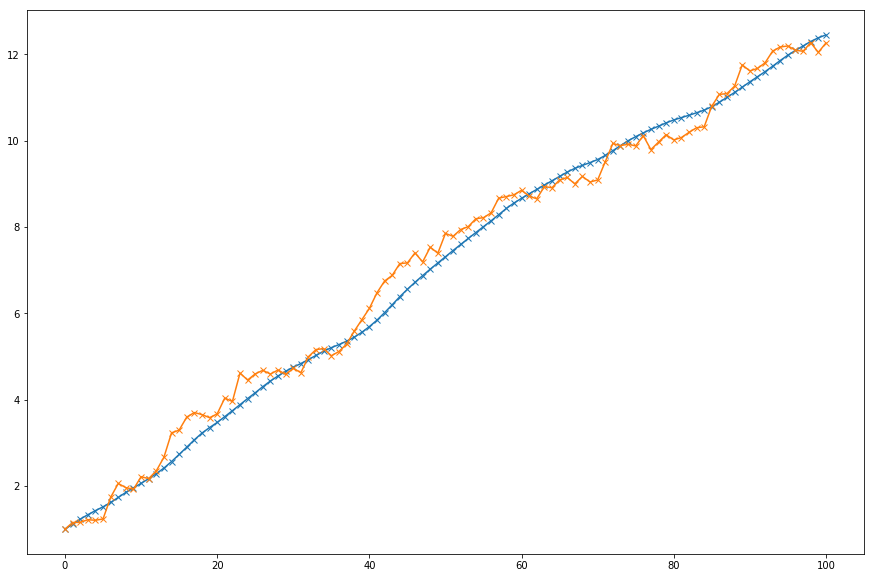

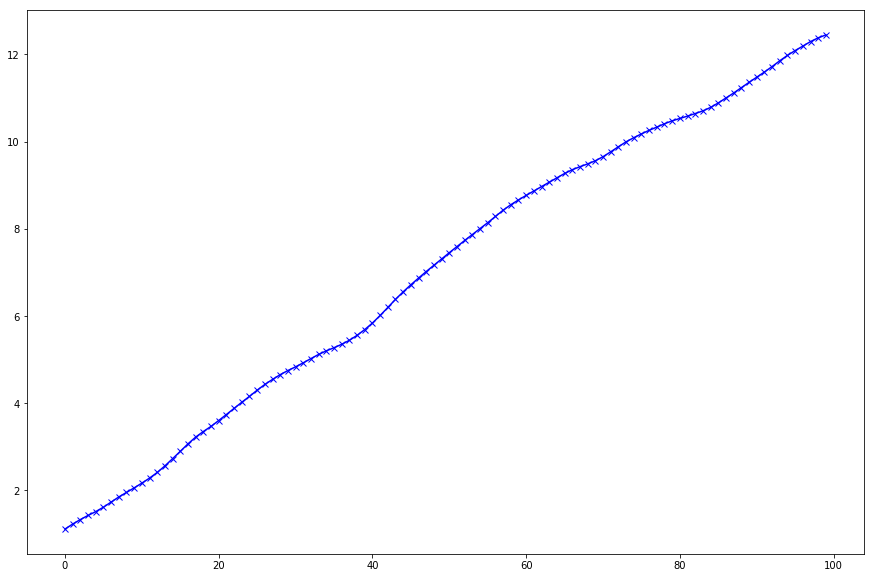

In [756]:
plt.figure(figsize=(15,10))
plt.plot(Z[0,:],'x-')
plt.plot(Z_post[0,:],'x-')
plt.figure(figsize=(15,10))
plt.plot(Z[0,1:],'bx-')